https://dash.harvard.edu/handle/1/42638988
https://www.medrxiv.org/content/10.1101/2020.03.09.20033357v1.full.pdf

# Recovery modeling

We will use the availavle data to model the recovery time.

The following assumptions are made:

## 1. Incubation Period:

The incubation period(I_period) is a Lognormal Distribution with mean equal to 5.6 days and standard deviation of 2.8.


Upon infection, the I_period will be sampled from this distribution.

When someone is infected, it takes I_period for them to become infectious. When someone has been infected for I_incubation days, we say that the we have the onset of the simptomns.

## 2. Onset to Hospitalization

Once someon start showing simptons, we say that the person takes H_period to be hospitalized. Here, we will model that this is the period where the person becomes infectious.

We are going to assume that in those infected, we have three groups: individuals who are
asymptomatic or have mild symptoms (95.6%), individuals who are hospitalized but do not
require critical care (3.08%), and individuals who are hospitalized and require critical care (1.32%). https://www.imperial.ac.uk/media/imperial-college/medicine/sph/ide/gida-fellowships/Imperial-College-COVID19-NPI-modelling-16-03-2020.pdf

We are going to assume that, after the H_period, a person will either be hospitalized or cured (recovered).

So in the general population, we will make the pessimistic estimation that someone infected has a 5% chance of needing hospitalization.

The H_period will be modeled as a gamma function.

If the person is either going to not need to be hospitalized or survive hospitalization, the H_period is equal to Gamma(mean=3.3, SD = 4.2).

However, if the person is going to die afterwards (here, the same as needing critical care), we have the H_period as Gamma(mean=6.5, SD = 4.0).

For both cases, we consider this to be the end of the infectiouness period.

## Hospitalization to outcome


https://careporthealth.com/wp-content/uploads/2020/04/COVID-19-Mortality-Report.pdf

The Mortality rates are assumed as following:

85+ -> 40%
65-84 -> 31%
55-64 -> 23%
45-54 -> 9%
20-44 -> 4%
0-19 -> 1%

With the distribution of hospitalizations among the age groups following:

85+ -> 8%
75-84 -> 15%
65-74 -> 20%
55-64 -> 21%
45-54 -> 15%
20-44 -> 19%
0-19  ->  2%

This way, we can average out the mortality rate of someone dying once it has been hospitalized as equal to: 35%

We were not able to find how long it takes for one patient to be cured, only for those addmited to die. So we will model both cases as follows:

Time from hospitalization to death equal to a Weibull distribution with mean equal to 8.9 days and standard deviation of 5.4

In [1]:
import numpy as np

mortality = {
            '85+' : 40,
            '65-84' : 31,
            '55-64' : 23,
            '45-54' : 9,
            '20-44' : 4,
            '0-19' : 1 
            }

distribution = {
    '85+' : 8,
    '65-84' : 35,
    '55-64' : 21,
    '45-54' : 15,
    '20-44' : 19,
    '0-19' : 2
}

np.mean(np.array(list(mortality.values())) * np.array(list(distribution.values())))/1000


0.3501666666666667

In [2]:
from scipy.special import gamma as gamma_func
from scipy.stats import weibull_min

In [3]:
def incubation_period(mean=None, sigma=None, log_mean=1.611195, log_sigma=0.47238):
    if mean and sigma:
        log_mean = np.log(mean) - .5*np.log(((sigma/mean)**2)+1)
        log_sigma = np.sqrt(np.log((sigma/mean)**2 + 1))
        
    return np.ceil(np.random.lognormal(mean=log_mean, sigma=log_sigma))

def needs_hospitalization(chance_of_hosp = 0.05):
    return np.random.random() < chance_of_hosp
    
def onset_to_hosp(mean_living = None, sigma_living = None,
                  mean_dead = None, sigma_dead = None,
                  shape_living=0.61735, scale_living=5.34545,
                  shape_dead=109.91155, scale_dead=0.05914,
                  survival_rate=.65, living = -1):
    
    if living == -1:
        living = np.random.random() < survival_rate
    
    if living:
        if mean_living and sigma_living:
            shape_living = (mean_living**2)/(sigma_living**2)
            scale_living = (sigma_living**2)/mean_living
        return np.ceil(np.random.gamma(shape_living, scale_living))
    
    else:
        if mean_dead and sigma_dead:
            shape_dead = (mean_dead**2)/(sigma_dead**2)
            scale_dead = (sigma_dead**2)/mean_dead
        return np.ceil(np.random.gamma(shape_living, scale_living))
        
def time_of_recovery(mean=None, sigma=None, shape=1.72051, scale=9.98274):
    if mean and sigma:
        shape = (sd/mean)**(-1.086)
        scale = mean/(gamma_func(1 + 1/shape))
        
    return np.ceil(weibull_min.rvs(c = shape, scale=scale))

    
def infection_timeline(day):
    timeline = {}
    timeline['infection_day'] = day
    timeline['end_of_incubation'] = day + incubation_period()
    timeline['contacts_infected'] = 0
    timeline['status'] = 'exposed'
    if needs_hospitalization():
        timeline['hospitalization'] = timeline['end_of_incubation'] + onset_to_hosp()
        timeline['removed'] = timeline['hospitalization'] + time_of_recovery()
    else:
        timeline['hospitalization'] = -1
        timeline['removed'] = timeline['end_of_incubation'] + onset_to_hosp(living=False)
    return timeline

In [4]:
def update_node_status(node, day):
    if node['infection_day'] != -1 and node['status'] != 'removed':
        if day >= node['end_of_incubation']:
            if node['hospitalization'] == -1:
                if day < node['removed']:
                    node['status'] = 'infected'
                else:
                    node['status'] = 'removed'
            elif day < node['hospitalization']:
                node['status'] = 'infected'
            elif day < node['removed']:
                node['status'] = 'hospitalized'
            else: 
                node['status'] = 'removed'

In [16]:
node = infection_timeline(0)
node['status'] = 'exposed'
print(node)
for i in range(1, 100):
    if node['status'] == 'removed': break
    update_node_status(node, i)
    print(f"{i}: {node['status']}")

{'infection_day': 0, 'end_of_incubation': 3.0, 'contacts_infected': 0, 'status': 'exposed', 'hospitalization': 8.0, 'removed': 11.0}
1: exposed
2: exposed
3: infected
4: infected
5: infected
6: infected
7: infected
8: hospitalized
9: hospitalized
10: hospitalized
11: removed


In [183]:
import os
os.chdir("../../")

import numpy as np
from src.visualization.graph_plot_utils import plot_graph, plot_infection
import collections, functools, operator 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

In [7]:
# Start with pct% of population infected
def init_graph(initial_infection = .05, graph_model = 'relaxed_caveman', pop_size = 1000):
    if graph_model == 'relaxed_caveman':
        G = nx.relaxed_caveman_graph(int(pop_size/4), 4, 0.25, seed=42)
    elif graph_model == 'scale_free':
        G = nx.scale_free_graph(pop_size)
    else:
        raise ValueError("Unknown graph type")
        
    init_infection(G, initial_infection)

    return G

def init_parameters(initial_infection, graph_model):
    G = init_graph(initial_infection, graph_model)
    
    status = current_status(G)
    
    pop = len(G.nodes)
    i = status['infected'] / pop
    s = (pop - i) / pop
    newly_infected = status['infected']
    r, contacts_infected = 0, 0

    data = [[s,i, r, newly_infected, contacts_infected]]

    return G, data, status, pop

def init_infection(G, pct):
    """
    Given a Graph G, infects pct% of population and set the remainder as susceptible.
    This is considered day 0.
    """
    size = int(len(G.nodes) * pct) 
    infected = np.random.choice(G.nodes, size = size)
    
    for node in G.nodes():
        if node in infected: 
            G.nodes[node].update(infection_timeline(0))
        else:
            G.nodes[node].update({'status': 'susceptible', 
                                  'infection_day' : -1, 
                                  'contacts_infected': 0})



def recover_one_step(G, day):
    """
    Recover everyone that has been infected recover_time days or more
    """

    for node, adjacencies in enumerate(G.adjacency()):
        update_node_status(G.nodes[node], day)


def spread_one_step(G, day, p_r = 0.5, lambda_leak = 0.05):
    """
    Spreads the infection 1 step, to the susceptible neighbours of infected people
    day is current day
    """
    newly_infected = []
       
    for node, adjacencies in enumerate(G.adjacency()):
        if G.nodes[node]['status'] == 'susceptible':
            if np.random.random() < lambda_leak:
                newly_infected.append(node)    
            else:
                for contact in adjacencies[1].keys():
                    if G.nodes[contact]['status'] == 'infected' and np.random.random() < p_r:
                            newly_infected.append(node)
                            G.nodes[contact]['contacts_infected'] += 1
                            break  
        
    for node in np.unique(newly_infected):
        G.nodes[node].update(infection_timeline(day))
        
    return len(newly_infected)


def simulate_one_step(G, day, recover_time=12, p_r=0.5, infectious_window=[4,6]):
    """
    Recover and Spread one step
    """
    recover_one_step(G, day, recover_time)
    newly_infected =  spread_one_step(G, day, p_r, infectious_window)
    return newly_infected

def current_status(G):
    """
    Returns a dict containing the current status of susceptible, infected and recovered
    """
    nodes = np.array(G.nodes(data=True))[:,1]
    result = collections.Counter(node['status'] for node in nodes)
    return result
    
    
def simulate_pandemic(initial_infection=.05, recover_time=12, p_r=.5, 
                          lambda_leak=.05, graph_model = 'relaxed_caveman'):
    """
    Runs the course of the pandemic from the start until
    less than 1% of the population is simultaneously infected or no one is infected
    """
    
    G, data, status, pop = init_parameters(initial_infection, graph_model)

    day = 0
    while (status['removed']+status['susceptible'])<pop:
        day +=1
        
        recover_one_step(G, day)
        
        newly_infected = spread_one_step(G, day, p_r, lambda_leak)
       
        status = current_status(G)
        i = status['infected'] / pop
        x = status['exposed'] / pop
        s = status['susceptible'] / pop
        r = status['removed'] / pop
        h = status['hospitalized'] / pop
        
        contacts_infected = [node['contacts_infected'] for i, node in G.nodes(data=True) if node['status'] == 'recovered']
        if len(contacts_infected) > 0: 
            contacts_infected = np.mean(contacts_infected)
        else:
            contacts_infected = np.nan
        data.append([s, i, x, r, h, newly_infected, contacts_infected])
    columns = ['susceptible', 'infected', 'exposed',
               'removed', 'hospitalized', 'newly_infected', 'contacts_infected_mean']

    time_series = pd.DataFrame(data, columns=columns)
    
    return time_series


KeyError: 'exposed'

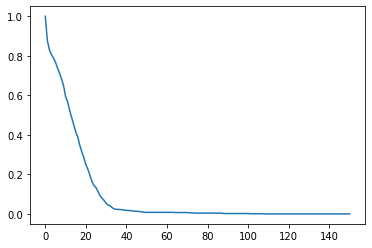

In [212]:
time_series, G = simulate_pandemic(p_r = 0.5, lambda_leak=.01)

plt.plot(time_series.index, time_series['susceptible'], label = 'susceptible')
plt.plot(time_series.index, time_series['infected'] + time_series['exposed'],
         label = 'infected + exposed')
plt.plot(time_series.index, time_series['removed'], label = 'recovered')
plt.legend()
plt.title('Relaxed Caveman')
plt.show()

In [69]:
exposed = np.zeros(1000)
day = 0
while not all(exposed):
    day += 1
    for x,p in enumerate(exposed):
        if not exposed[x]:
            if np.random.random() < 1/6 or day > 20:
                exposed[x] = day              

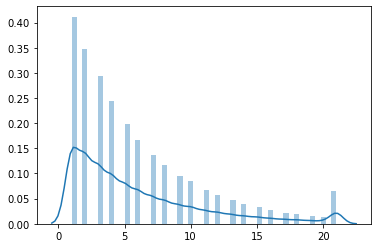

In [70]:
import seaborn as sns
sns.distplot(exposed)

In [72]:
np.median(exposed)

4.0

5.836


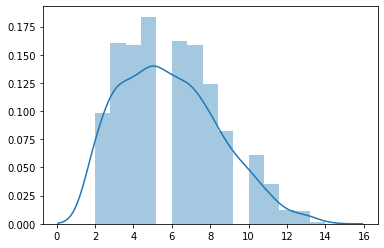

In [176]:
import numpy as np
from scipy.stats import truncnorm
import seaborn as sns

#https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7014672/
    
def sample_incubation(clip_low = 2, clip_high = 15, mean = 6, std = 3):
    a, b = (clip_low - mean) / std, (clip_high - mean) / std

    return int(truncnorm.rvs(a, b, mean, std))



print(np.mean([sample_incubation() for x in range(1000)]))
sns.distplot([sample_incubation() for x in range(1000)])

In [260]:
def sample_truncated_norm(clip_low, clip_high, mean, std):
    a, b = (clip_low - mean) / std, (clip_high - mean) / std
    return int(truncnorm.rvs(a, b, mean, std))

def sample_incubation(clip_low = 2, clip_high = 15, mean = 6, std = 3):
    return sample_truncated_norm(clip_low, clip_high, mean, std)

def sample_onset_to_hosp_or_asymp(clip_low = 2, clip_high = 21, mean = 6.2, std = 4.3):
    return sample_truncated_norm(clip_low, clip_high, mean, std)

def sample_hospitalization_to_removed(clip_low = 2, clip_high = 32, mean = 8.6, std = 6.7):
    return sample_truncated_norm(clip_low, clip_high, mean, std)

def sample_needs_hospitalization(chance_of_hosp = 0.05):
    return np.random.random() < chance_of_hosp

def susceptible_to_exposed(node, day):
    if node['status'] != 'susceptible':
        print(node)
        raise ValueError("Node status different from susceptible")
    
    node['status'] = 'exposed'
    node['period_duration'] = sample_incubation()
    node['infection_day'] = day
    
    return

def exposed_to_infected(node):
    if node['status'] != 'exposed':
        raise ValueError("Node status different from exposed")
    if node['period_duration'] > 0:
        raise ValueError("Not yet time to change")
    
    node['status'] = 'infected'
    node['period_duration'] = sample_onset_to_hosp_or_asymp()
    
    return
    
def infected_to_new_state(node):
    if node['status'] != 'infected':
        raise ValueError("Node status different from infected")
    if node['period_duration'] > 0:
        raise ValueError("Not yet time to change")
    
    if needs_hospitalization():
        node['status'] = 'hospitalized'
        node['period_duration'] = sample_hospitalization_to_removed()
    else:
        node['status'] = 'removed'
        
    return
        
def hospitalized_to_removed(node):
    if node['status'] != 'hospitalized':
        raise ValueError("Node status different from hospitalized")
    if node['period_duration'] > 0:
        raise ValueError("Not yet time to change")
        
    node['status'] = 'removed'
    
    return

def change_state(node):
    if node['status'] == 'exposed':
        exposed_to_infected(node)
        return
    if node['status'] == 'infected':
        infected_to_new_state(node)
        return 
    if node['status'] == 'hospitalized':
        hospitalized_to_removed(node)
        return 

def update_node(node):
    if node['status'] == 'susceptible' or node['status'] == 'removed':
        return
    if node['period_duration'] == 0: 
        change_state(node)
        return 
    
    node['period_duration'] = node['period_duration'] - 1
    return

def infect_node(node, day):
    susceptible_to_exposed(node, day)
    return

def infect_graph(Graph, node_list, day):
    for n in node_list:
        infect_node(Graph.nodes[n], day)

def update_graph(Graph):
    for i, node in Graph.nodes(data=True):
        update_node(node)
        

In [274]:
import networkx as nx
import numpy as np
import pandas as pd
import collections

# Start with pct% of population infected
def init_graph(initial_infection = .05, graph_model = 'relaxed_caveman',
               pop_size = 1000, seed = None):
    if graph_model == 'relaxed_caveman':
        G = nx.relaxed_caveman_graph(int(pop_size/4), 4, 0.25, seed)
    elif graph_model == 'scale_free':
        G = nx.scale_free_graph(pop_size, seed=seed)
    else:
        raise ValueError("Unknown graph type")
        
    init_infection(G, initial_infection)

    return G

def init_parameters(initial_infection, graph_model, pop_size = 1000, seed=None):
    G = init_graph(initial_infection, graph_model, pop_size, seed)
    
    status = current_status(G)
    
    pop = len(G.nodes)
    i = status['infected'] / pop
    s = (pop - i) / pop
    newly_infected = status['infected']
    r, contacts_infected = 0, 0

    data = [[s,i, r, newly_infected, contacts_infected]]

    return G, data, status, pop

def init_infection(G, pct):
    """
    Given a Graph G, infects pct% of population and set the remainder as susceptible.
    This is considered day 0.
    """   
    for node in G.nodes():
        G.nodes[node].update({
                      'status': 'susceptible', 
                      'infection_day' : -1, 
                      'contacts_infected' : 0
        })

    size = int(len(G.nodes) * pct) 
    print(size)
    infected = np.random.choice(G.nodes, size = size, replace = False)
    
    for i in infected:
        susceptible_to_exposed(G.nodes[i], 0)

def recover_one_step(G, day, recover_time = 12):
    """
    Recover everyone that has been infected recover_time days or more
    """

    for node, adjacencies in enumerate(G.adjacency()):
        if G.nodes[node]['status'] == 'infected':
            if np.random.random() < 1/15:
                G.nodes[node]['status'] = 'removed'
            #if day - G.nodes[node]['infection_day'] >= recover_time: 
            #    G.nodes[node]['status'] = 'removed'

def spread_one_step(G, day, p_r = 0.5, lambda_leak = 0.05):
    """
    Spreads the infection 1 step, to the susceptible neighbours of infected people
    day is current day
    """
    newly_infected = []
       
    for node, adjacencies in enumerate(G.adjacency()):
        if G.nodes[node]['status'] == 'susceptible':
            if np.random.random() < lambda_leak:
                newly_infected.append(node)    
            else:
                for contact in adjacencies[1].keys():
                    if G.nodes[contact]['status'] == 'infected' and np.random.random() < p_r:
                            newly_infected.append(node)
                            G.nodes[contact]['contacts_infected'] += 1
                            break  
        
    newly_infected = np.unique(newly_infected)
    
    infect_graph(G, newly_infected, day)
    
    return newly_infected.size


def simulate_one_step(G, day, recover_time=12, p_r=0.5, infectious_window=[4,6]):
    """
    Recover and Spread one step
    """
    recover_one_step(G, day, recover_time)
    newly_infected =  spread_one_step(G, day, p_r, infectious_window)
    return newly_infected

def current_status(G):
    """
    Returns a dict containing the current status of susceptible, infected and removed
    """
    nodes = np.array(G.nodes(data=True))[:,1]
    result = collections.Counter(node['status'] for node in nodes)
    return result

def get_mean_contacts_infected(G):
        contacts_infected = [node['contacts_infected'] for i, node in G.nodes(data=True)\
                                                             if node['status'] == 'removed']
        if len(contacts_infected) > 0: 
            contacts_infected = np.mean(contacts_infected)
        else:
            contacts_infected = np.nan
            
        return contacts_infected
    
def get_time_series_row(G, pop):
    status = current_status(G)
    s = status['susceptible'] / pop
    i = status['infected'] / pop
    r = status['removed'] / pop

    contacts_infected = get_mean_contacts_infected(G)
    
    return s, i, r, contacts_infected, status
    
def simulate_pandemic(initial_infection=.05, recover_time=12, p_r=.5, lambda_leak=.05,
                      graph_model = 'relaxed_caveman', pop_size = 1000,
                      seed = None):
    """
    Runs the course of the pandemic from the start until
    less than 1% of the population is simultaneously infected or no one is infected
    """
    
    np.random.seed(seed)
    
    G, data, status, pop = init_parameters(initial_infection, graph_model, pop_size, seed)

    for day in range(150):
        
        if (status['removed']+status['susceptible'])>=pop:
            break
    
        update_graph(G)
        
        newly_infected = spread_one_step(G, day, p_r, lambda_leak)
       
        s, i, r, contacts_infected, status = get_time_series_row(G, pop)

        data.append([s, i, r, newly_infected, contacts_infected])
        
    columns = ['susceptible', 'infected', 'removed', 'newly_infected', 'contacts_infected_mean']

    time_series = pd.DataFrame(data, columns=columns)
    
    return time_series, G


100


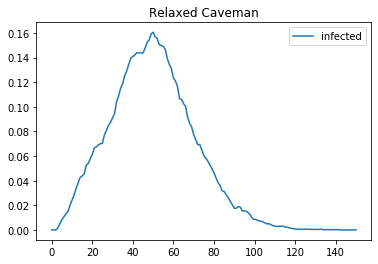

In [290]:
time_series, G = simulate_pandemic(p_r = 0.5, lambda_leak=0, pop_size=5000, 
                                initial_infection = 100/5000)

#plt.plot(time_series.index, time_series['susceptible'], label = 'susceptible')
plt.plot(time_series.index, time_series['infected'], label = 'infected')
#plt.plot(time_series.index, time_series['removed'], label = 'removed')
plt.legend()
plt.title('Relaxed Caveman')
plt.savefig('relaxed_caveman_simulation.png', fromat='png', dpi = 300)
plt.show()

In [237]:
time_series

,susceptible,infected,recovered,newly_infected,contacts_infected_mean
0,1.0000,0.0000,0.0,0,0.0
1,0.9896,0.0000,0.0,51,NaN
2,0.9774,0.0000,0.0,61,NaN
3,0.9674,0.0000,0.0,50,NaN
4,0.9542,0.0008,0.0,66,NaN
...,...,...,...,...,...
146,0.0008,0.0000,0.0,0,NaN
147,0.0008,0.0000,0.0,0,NaN
148,0.0008,0.0000,0.0,0,NaN
149,0.0008,0.0002,0.0,0,NaN


In [265]:
pd.Series([3144 2579 2658 2473 4686 3662 3203 4421 1006 4169 3234 4479 4427  991
 3152  620  209 3186 4352 1545 3962 3733 4294 2823 3618 3433 1630 2335
 1814  501 2353 3080 4862 4029  804  116 1471 3813  471 3748  949 3817
 1660 4193 4375 1154 2346 2910  445 1750 2779 2012 3137 1413  134 2147
 4382  408 2991 4374 3860 2388 4742 2554   45 3579 3826 3071 4856 3054
  788 4880 2522 3321 4444 3705  778 2854 2214 3743 3202 2534    0 4841
 3601  439 2475 3556 1741 1586  456 3618 3704  959 2900  360 4548 2521
  147 2031  859 3108 2083 4500  780 1042  393 4166 1507 1165 1190 1625
 4669 1536  348 2920  903 3387 2627 2520 2041 2337 2597  458 3686 2260
 2402 4152 2326  667  560 4346  137 2235  460  468 4778 1394 2815 2929
  137 3199 2459 2066 1078 3927 1300  125 3322 4887 4059 1308 2567 2117
 3651 2939  680 3627 4063 4577 1727  511 3033 1081 1564 3566 4824 4705
 1565 2111 2908 3226 4470 4286 4559 4087 4942 3191 2509 1822  853 3246
  630 4895 1672 2811  711 3899 1936 1220 4674 3747 3009 2382 4151 2608
 4913 2206  597 3662 1374  964  757 1523 4394 4383 3637 1375 2644 4544
 1892 3154 4464  842  378  901 1357 3191 1951 4789 2347  411 4647 2747
  638 3415 3736 2827 4181 4179 2431 3815 4036 3298 3174 4594 4291 2995
 1258  422 3673 4164  402 3394 1131 4714 1567  519 1703 3100  110 4367
 2816 3950 2855 1491 2403  637 2243 3429 2392 1313 2659 2363  666 2729
  191 4995 1127 3908 4604  735 1426 2189  420 3476 3029 4656 3346 4296
 1112 2189 1983 3251  893 2836 2126 3757 2825 4778 2317 3659 2533 4708
 2857 2240 2072 1778 2769 4946 3362 1230 2566 4664 1056 1710 4755  208
 4497 4362 3685 2360 4179  263 1005 2080  955 1020  741  188  278 2729
 1701 3327 3276  629  416 1735  541 2575 2319  324  811 4838 4750   44
 3441 3881 2920 3950 4722 3257  120 3781 2556 4480 2258 2383 2093  213
 3428 2887 2476  816 4842  312 2098 3502 4420 4923 1000 3128  437 3117
 4348 3706 1628 1950 1839 3343  703 3444 3790 1004 4109 2232 4889 3832
 4156 3996 4810 3943 1833 3936 2987 3221 4715 2605  437 4352 2756 3344
    6 1360 1298 3694 4665 4719 1158 4543 4801 1311  230 3641 3931  537
 4307 1686 4892 1428 1954 4808 2351 4008  123 1581 2864 4720 4224 1144
 1836 4224 1673 1665 4055  346 1389 2104  365 3633 4219 3769 2112 1565
 2139 1162 1965 4419  963 1602 4968 3405 3727 3771 4485 1017 2110 1141
 4581 4301  914 1384 1456 1371 3741 1714 3459 4642 4360   81  465 1008
  655 1777 4448 4924 2253  294  285 3019 4807  807 1193 1076 1840  938
 2642 2305 2786  783 4423 1995 3149 4669 4760  853 1060 1589 4908 3389
 1818 2040   46 1491 1878 1082 4717  878 1387  585 2962  695 4480  250
 1926 3418 2100 4368 1994 3527 3917  166 1081 4833 3611 3513 1824 2521
 4269 4670  458 2724 2248 4585 3059 2337 4035  375 3427 3520 3052   82
  341 3807  162 2879 4044 4606  260   81 4255 3462 3548 1213 2139 3121
 3638 3804 1594 3423 4407 2719  582  640 3333 1012  755  540 2058 1865
 1114  601 2624 3120 3083 1929 2103 2084 3201 4345 2378 2088 2313 1205
  981 2908 2631 3799 3513   26 4603 4252 2976 3166  631 3014 2721 2352
 1363 2340  180   25 2286 2479  131  456 1286 2334 4364 2335 4196 2284
 1828 3806 4322 2493 1059 2919 4140 1548 3617 3000 3661 4582 3856 4471
 2596  784 3236 3342 4674 4010 4898 1243 1593 1799 2559 2891 1253 3863
   86 2001  851 1685  593 4505 2363 1239 2463 1755 1186 3716 4455 3604
 1511 1694 3251 2208 3405  474 2316 2130 1122 2960 4227 3328 1191  250
 3944 1534 2430 1111 2005 4282  653 3026 3874  668 4820 4485 2485  549
 1807 1151  243 3685 1738 1504 3267   28 1916 1207  527 1876 3387 1362
 1507 4808   10 4898 2688 1022 2598 4204  950 2539 4425 4649 3931 1560
 3441 3590 1524  276 3724 1909 3888 1831 1001  764 3471 3842 4229 2141
 1364  787 4404 2998 3924 2067 4977 2383  619 1567 4333 3319 4706 3781
 2067 4402  243 2297 4014 4838 3567 3848 3293 4587 2409 2217 1175 3601
 4115 4888  381 4319 3720 2309 2518 2034 1819  788 4731 4131 4089 1102
 3782 4828 3674 2556 1453 1392 2807 1827 4072 2535  699 1003 2950 4113
  885 3180 3795 1508 3760 2348  992 3453 2400 3858 1062 2539 4615 1824
 3770 3473  246 2299 1080 1558 2680 4315 4192 3140 3381  720 2435 2735
 1861 4690  871  338  194 4156  227  971 3874 3076 4319 2679 1139 3262
 1762  617  965 3156 1367 3138 4330 4681  755 3494 1653 1356 4905 4410
  406 2215 4061 1978 3375 3960 1776 2107  926  655 2990 4765 2749  228
  724 3720 3834 1762 1043 2712 1497 3704 1328 3500  730 3644 2891 2676
 3108 4972 4761 1733 4916  419  393 2069 4691 2514 3216 4849 2023  889
 3733  992  211 2109 4683 1155 1324 3129 2293 2110 3609 3880  773 1576
 4772  572 4211 3431   90 4638  864 2161  902 4705 4393 1298 2000 3534
  673 1706 2588  976  288  376  246 1591 4282 4696 4744 4147 3988 4621
  227  228  543 3442 2999 2176 1464 4021 2379 4776 2222 3182 4495  943
 3821 3308  228 3203  894 2492 2347  150  200 2231 3307 4786  776 3512
 2640 2438 4919 4521 2560 2337  872  520 1079 1861 2801 1103  288  845
  227   28 3941 4597 1291 2831 3954  930 3443 4566 2005 4319 3207 4912
 2292  795 2623 3318 2865 3513 2801 4412 4091 2656 1446  499 4962 2647
 4276 3982 2852 4296  126 1479  400 3096 2591 3548 1221 1873 1535 1376
 2848 4913 1516  626  464 4858]).value_counts()

SyntaxError: invalid syntax (<ipython-input-265-97cfe2408511>, line 1)